# Bayesian inference using MCMC
***

## Markov Chain Monte Carlo with Metropolis-Hastings Sampler

This is a simple tutorial to illustrate how to use simulation in R to combine a dataset of interest with a model and generate posterior distributions of parameters of interest. Metropolis-Hastings is a very general Markov chain sampler and perhaps the easiest to understand and explain.

We need a dataset and a model to get started. The dataset will have (lab or field) observations of the phenomena of interest; the model will make in silico predictions of the same phenomena of interest. We will use a simple exposure model, but the model itself can be anything functional form (simple algebra, a regression, complex fate and transport process model, etc.)

## The data set

We will first import a dataset that has semi-field experimental observations of pesticide body burdens in terrestrial amphibians with covariates. In this case, we will use pesticide body burdens in amphibians. We will combine this with a model that also uses some of these covariates and makes predictions of amphibian pesticide body burdens.




In [32]:
# import data 
combined_data <- read.csv('../data_in/amphib_dermal_collated.csv')
which(combined_data$tissue_conc_ugg==min(combined_data$tissue_conc_ugg))
# delete 593:601 -- application units are off, for #797 measurements units are off
combined_data_drops <- combined_data[-c(593:601,797),]
head(combined_data_drops)


[1] 797

X,app_rate_g_cm2,application,body_weight_g,chemical,exp_duration,formulation,sample_id,soil_conc_ugg,soil_type,source,species,tissue_conc_ugg
1,5.58e-06,Overspray,1.73625,Imidacloprid,8,0,HGOI1,0.4798464,PLE,rvm2015,Barking treefrog,1.0152872
2,5.58e-06,Overspray,2.61111,Imidacloprid,8,0,HGOI2,0.4798464,PLE,rvm2015,Barking treefrog,1.6360832
3,5.58e-06,Overspray,1.82332,Imidacloprid,8,0,HGOI3,0.4798464,PLE,rvm2015,Barking treefrog,0.9261004
4,5.58e-06,Overspray,2.91551,Imidacloprid,8,0,HGOI4,0.4798464,PLE,rvm2015,Barking treefrog,0.7182776
5,5.58e-06,Overspray,2.49115,Imidacloprid,8,0,HGOI5,0.4798464,PLE,rvm2015,Barking treefrog,1.0890361
6,2.00e-05,Overspray,2.09766,Pendimethalin,8,0,HGOP1,12.1193484,PLE,rvm2015,Barking treefrog,2.1387952


The data set has pesticide body burdens for 788 amphibians. Also, we will use a couple of independent variables controlled in the experiment as predictors, pesticide application rate and the body weight of each of the amphibians. 
    

In [33]:
dim(combined_data_drops)
colnames(combined_data_drops)
#observed tissue concs
n <- length(combined_data_drops$tissue_conc_ugg)
measured_tissue_concs <- combined_data_drops$tissue_conc_ugg

[1] 788  13

[1] "X"               "app_rate_g_cm2"  "application"     "body_weight_g"  
 [5] "chemical"        "exp_duration"    "formulation"     "sample_id"      
 [9] "soil_conc_ugg"   "soil_type"       "source"          "species"        
[13] "tissue_conc_ugg"

## The model

We will also look at a simple exposure model that predicts body burdens in amphibians. One of the exposure parameters (dermal_af) has no information to support it, the EPA and EU have been guessing at protective but reasonable values to parameterize it. One value used has been a dermal_af of 0.5.

\begin{equation*}
Predicted\_tissue\_conc = \frac{(app\_rate * surface\_area * conv\_rate * \mathbf{dermal\_af)}}{body\_weight}
\end{equation*}


In [34]:
# Initializing some constants, making predictions with dermal_af = 0.5
app_rate <- combined_data_drops$app_rate_g_cm2
conv_rate <- 1000000.0
body_weight <- combined_data_drops$body_weight_g
sa_amphib_hutchinson <- 1.131 * (body_weight ^ 0.579)
# we are interested in this parameter dermal_af
dermal_af = 0.5
predicted_tissue_concs = (app_rate * sa_amphib_hutchinson * conv_rate * dermal_af)/body_weight

## Comparing measured and predicted tissue concentrations

Now we have measurements and predictions from a model of amphibian tissue concentrations. We can compare them in different ways (table, plot or statistically) to see how the model is doing.


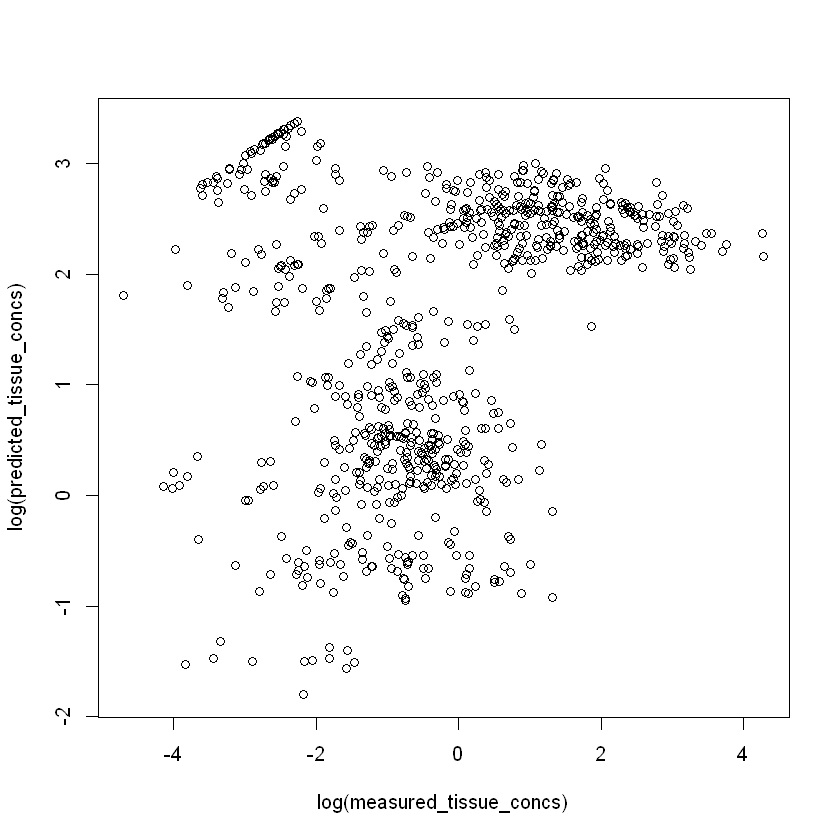

In [35]:
plot(log(measured_tissue_concs), log(predicted_tissue_concs))



Statistically, we can think about the likelihood of these 788 predicted model results for this single model run given the measured values we have for each amphibian if we make some distributional assumptions. The likelihood is the probability (density) with which we would expect the observed data to occur conditional on the parameters of the model that we look at. A common approach in modeling when comparing model predictions to measurement is to tweak the inputs in order to maximize this likelihood calculation. 

In [36]:
sd = 2 #making something up, this is a second parameter that we are uninformed about
singlelikelihoods = dnorm(measured_tissue_concs, mean = predicted_tissue_concs, sd = sd, log = T)
sumll = sum(singlelikelihoods)
sumll

[1] -10687.23

## Creating a likelihood function for our model

Above was a likelihood calculation for a particular parameterization of our model. Now we want to write a function that allows different inputs for the 2 parameters that we do not know much about, dermal_af from our model and sd from our likelihood calculation.

In [37]:
likelihood <- function(param){
  #dermal_af and sd are passed into this function via param
  dermal_af = param[1]
  sd = param[2]
  
  # this is the same model as above
  predicted_tissue_concs = (app_rate * conv_rate * sa_amphib_hutchinson * dermal_af)/body_weight
  # the probability of obtaining the test data above under this model
  # we simply calculate the difference between predictions the predicted y and 
  # the observed y, and then we have to look up the probability densities (using dnorm) 
  # for such deviations to occur, log set to True
  singlelikelihoods = dnorm(measured_tissue_concs, mean = predicted_tissue_concs, sd = sd, log = T)
  # sum the likelihoods across all the obeserved differences since we are in log-space
  # we sum the logs as convention to avoid numerical issues, etc.
  sumll = sum(singlelikelihoods)
  return(sumll)   
}

## Defining the prior distributions
***

We need to define what we think we know about the possibel values of dermal_af, as well as the random error sd

We will use wide uniform priors:
* dermal_af: uniform from 0 to 10
* sd: uniform from 0 to 10

Let's define a function that will return the prior probability for a pair of dermal_af and sd values

In [38]:
prior <- function(param){
  a = param[1]
  sd = param[2]
  aprior = dunif(a, min=0, max=4, log = T)
  sdprior = dunif(sd, min=0, max=10, log = T)
  return(aprior+sdprior)
}

## Defining the posterior function
***
The posterior is, by definition, the likelihood times the prior. Since we are working with log-likelihoods, we will add these terms.

In [39]:
posterior <- function(param){
  return (likelihood(param) + prior(param))
}

## The Metropolis-Hastings MCMC proposal function
***

Markov chain Monte Carlo (MCMC) is different from traditional Monte Carlo in how the proposed inputs are created. In traditional MC we would just create, for example, 10000 inputs for dermal_af in propogate them through the model to create 10000 predictions. In MCMC, the new set of inputs are conditional on the last set of accepted inputs. There are different ways to do this, but in Metropolis-Hastings we generate correlated variables from one draw to the next using the rnorm function.

So we need a function that takes a current parameter set and gives a new proposal set.

The s.d. in this function is often called the 'step length', and can be tuned to adjust the acceptance rate.

In [40]:
proposalfunction <- function(param){
  # draw 2 values from normal distributions for both dermal_af and sd 
  # the mean of the distribution is the last chain input and sds are specified in the sd input
  return(rnorm(2,mean = param, sd= c(0.1,0.3)))
}


## Metropolis-Hastings Sampling

Now we want a function that will run the entire simulation. We will pass some initial values for dermal_af and sd into the function, then it will use the above functions to go step by step through the chain. Importantly, after each simulation, we will compare the likelihood of the new simulation to the likelihood of the old simulation. If our new simulation is better then we keep it, if it is worse we will keep it with a probability equal to the relative likelihood versus the previous simulation.

In [41]:
#metropolis
run_metropolis_MCMC <- function(startvalue, iterations){
  chain = array(dim = c(iterations+1,3))
  chain[1,1:2] = startvalue
  for (i in 1:iterations){
    # create candidate inputs
    proposal = proposalfunction(chain[i,1:2])
    
    # compare the new simulation to the previous one
    probab = exp(posterior(proposal) - posterior(chain[i,1:2]))
    
    # decide to accept or reject the proposal
    if (runif(1) < probab){
      chain[i+1,1:2] = proposal #accept the new proposal
    }else{
      chain[i+1,1:2] = chain[i,1:2] #reject the new proposal and keep the previous one
    }
    chain[i+1,3] <- probab # save the acceptance probability in the chain
  }
  return(chain)
}

## Running the MCMC sampler
***
Now we are ready to run the simulations. We need to provide some starting values for the inputs and tell the simulation function how many iterations we are interested in.


In [42]:
startvalue = c(1,2) # give some initial values for dermal_af and sd
iterations = 50000
chain = run_metropolis_MCMC(startvalue, iterations)

We saved the results in the chain function. For our purposes today we are interested in the accepted inputs of dermal_af and sd.


In [43]:
dim(chain)
summary(chain)
burnIn = 5000
acceptance = 1-mean(duplicated(chain[-(1:burnIn),1:2]))
acceptance
chain_burnfree <- chain[-(1:burnIn),]
chain_burnfree[which(chain_burnfree[,3]>1),3] <- 1


[1] 50001     3

       V1                V2              V3         
 Min.   :0.03312   Min.   :2.000   Min.   :0.00000  
 1st Qu.:0.13586   1st Qu.:6.269   1st Qu.:0.00000  
 Median :0.14407   Median :6.374   Median :0.00000  
 Mean   :0.14390   Mean   :6.373   Mean   :    Inf  
 3rd Qu.:0.15106   3rd Qu.:6.480   3rd Qu.:0.00269  
 Max.   :1.10320   Max.   :7.002   Max.   :    Inf  
                                   NA's   :1        

[1] 0.0876425

## Visualize the chain output

Generally, Monte Carlo sampling generates independent samples from the input variables when simulating. However, Metropolis-Hastings is significantly different in that it generates correlated variables from one draw to the next. This is a big switch from more traditional Monte Carlo approaches based on importance sampling.

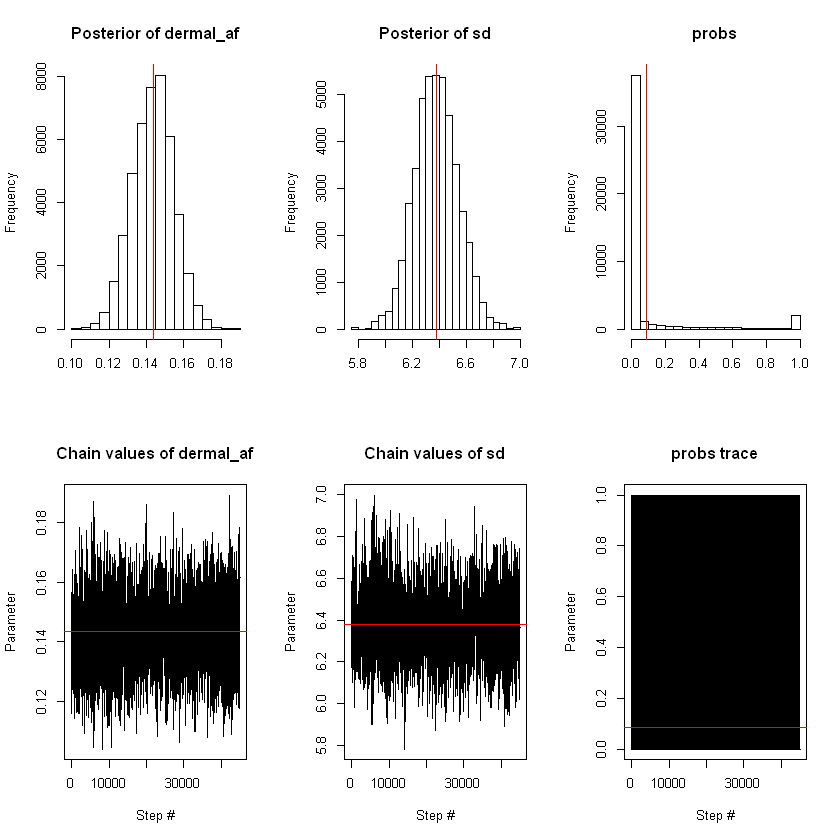

In [44]:
par(mfrow = c(2,3))
hist(chain_burnfree[,1],nclass=30, , main="Posterior of dermal_af", xlab="")
abline(v = mean(chain_burnfree[,1]), col="red")
hist(chain_burnfree[,2],nclass=30, main="Posterior of sd", xlab="")
abline(v = mean(chain_burnfree[,2]), col="red" )
hist(chain_burnfree[,3],nclass=30, main="probs", xlab="")
abline(v = mean(chain_burnfree[,3]), col="red" )
plot(chain_burnfree[,1], type = "l", xlab="Step #" , ylab = "Parameter", main = "Chain values of dermal_af", )
abline(h = mean(chain_burnfree[,1]), col="red" )
plot(chain_burnfree[,2], type = "l", xlab="Step #" , ylab = "Parameter", main = "Chain values of sd", )
abline(h = mean(chain_burnfree[,2]), col="red" )
plot(chain_burnfree[,3], type = "l", xlab="Step #" , ylab = "Parameter", main = "probs trace", )
abline(h = mean(chain_burnfree[,3]), col="red" )